# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
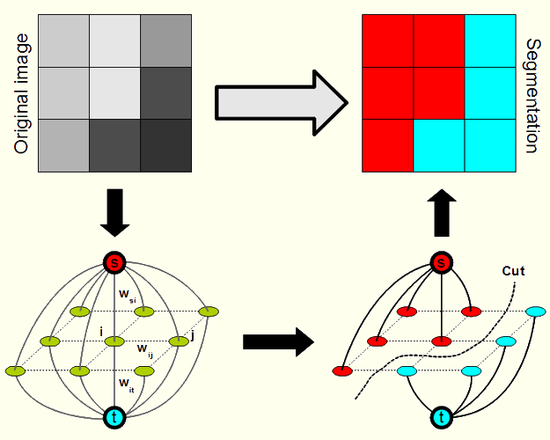

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import igraph as ig

In [11]:
COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
# Additional variables SREE 
DRAW_PR_FG = {'color': COLORS['GREEN'], 'val': 3}
DRAW_PR_BG = {'color': COLORS['RED'], 'val': 2}

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            print(' *****EVENT ***** LBUTTON DOWN')
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            print(' *****EVENT ***** LBUTTON UP')
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
                skip_learn_GMMs = True

In [48]:
# Grabcut implementation 
class GrabCut:
    def __init__(self, img, mask, rect=None, k_components=5):
        self.img = np.asarray(img, dtype=np.float64)
        self.rows, self.columns, _ = img.shape

        self.mask = mask
              
             
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3],
                      rect[0]:rect[0] + rect[2]] = DRAW_PR_FG['val']
        self.label_pixels()

        # Best number of GMM components K suggested in paper
        self.k_components = k_components
        #self.gamma = 50  # Best gamma suggested in paper formula (5)
        #self.gamma = 100 
        self.gamma = 25
        self.beta = 0

        self.left_V = np.empty((self.rows, self.columns - 1))
        self.upleft_V = np.empty((self.rows - 1, self.columns - 1))
        self.up_V = np.empty((self.rows - 1, self.columns))
        self.upright_V = np.empty((self.rows - 1, self.columns - 1))

        self.bgd_gmm = None # Initialize backgraound gmm
        self.fgd_gmm = None # Initialize foreground gmm
        self.comp_idxs = np.empty((self.rows, self.columns), dtype=np.uint32)#Initialize image indexes

        self.gc_graph = None
        self.gc_graph_capacity = None           # Edge capacity
        self.gc_source = self.columns * self.rows  # Terminal S
        self.gc_sink = self.gc_source + 1       # Terminal T
                

        self.calculate_beta_and_V()
        self.initialize_GMMs()
        self.run()

    def calculate_beta_and_V(self):
        _left_diff = self.img[:, 1:] - self.img[:, :-1]
        _upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1]
        _up_diff = self.img[1:, :] - self.img[:-1, :]
        _upright_diff = self.img[1:, :-1] - self.img[:-1, 1:]

        self.beta = np.sum(np.square(_left_diff)) + np.sum(np.square(_upleft_diff)) + \
            np.sum(np.square(_up_diff)) + \
            np.sum(np.square(_upright_diff))
        self.beta = 1 / (2 * self.beta / (
            # Each pixel has 4 neighbors (left, upleft, up, upright)
            4 * self.columns * self.rows
            # The 1st column doesn't have left, upleft and the last column doesn't have upright
            - 3 * self.columns
            - 3 * self.rows  # The first row doesn't have upleft, up and upright
            + 2))  # The first and last pixels in the 1st row are removed twice
        print('Beta:', self.beta)

        # Smoothness term V described in formula (11)
        self.left_V = self.gamma * np.exp(-self.beta * np.sum(
            np.square(_left_diff), axis=2))
        self.upleft_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(
            np.square(_upleft_diff), axis=2))
        self.up_V = self.gamma * np.exp(-self.beta * np.sum(
            np.square(_up_diff), axis=2))
        self.upright_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(
            np.square(_upright_diff), axis=2))

    def label_pixels(self):
        self.bgd_indexes = np.where(np.logical_or(
            self.mask == DRAW_BG['val'], self.mask == DRAW_PR_BG['val'])) # pick all backgraound indexes which are labeled as 0 and 2
        self.fgd_indexes = np.where(np.logical_or(
            self.mask == DRAW_FG['val'], self.mask == DRAW_PR_FG['val']))# pick all foreground indexes which are labeled as 1 and 3

        assert self.bgd_indexes[0].size > 0
        assert self.fgd_indexes[0].size > 0

        print('(pr_)bgd count: %d, (pr_)fgd count: %d' % (
            self.bgd_indexes[0].size, self.fgd_indexes[0].size))

    def initialize_GMMs(self):
        print('initialize_GMMs')
        self.bgd_gmm = GaussianMixtureModel(self.img[self.bgd_indexes]) # cluster pixels belongs to background
        self.fgd_gmm = GaussianMixtureModel(self.img[self.fgd_indexes]) # cluster pixels belongs to foreground
         

    def assign_GMMs_components(self):
        # assign background gmm components to background pixels and foreground gmm components to foreground pixels
        self.comp_idxs[self.bgd_indexes] = self.bgd_gmm.which_component(
            self.img[self.bgd_indexes])
        self.comp_idxs[self.fgd_indexes] = self.fgd_gmm.which_component(
            self.img[self.fgd_indexes])

    def learn_GMMs(self):
        
        self.bgd_gmm.fit(self.img[self.bgd_indexes],
                         self.comp_idxs[self.bgd_indexes])
        self.fgd_gmm.fit(self.img[self.fgd_indexes],
                         self.comp_idxs[self.fgd_indexes])

    def construct_mincut_graph(self):
        print('construct_mincut_graph')
        bgd_indexes = np.where(self.mask.reshape(-1) == DRAW_BG['val'])
        fgd_indexes = np.where(self.mask.reshape(-1) == DRAW_FG['val'])
        pr_indexes = np.where(np.logical_or(
            self.mask.reshape(-1) == DRAW_PR_BG['val'], self.mask.reshape(-1) == DRAW_PR_FG['val']))

        print('bgd count: %d, fgd count: %d, uncertain count: %d' % (
            len(bgd_indexes[0]), len(fgd_indexes[0]), len(pr_indexes[0])))

        edges = []
        self.gc_graph_capacity = []

        # t-links
        edges.extend(
            list(zip([self.gc_source] * pr_indexes[0].size, pr_indexes[0])))
        _D = -np.log(self.bgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * pr_indexes[0].size, pr_indexes[0])))
        _D = -np.log(self.fgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_source] * bgd_indexes[0].size, bgd_indexes[0])))
        self.gc_graph_capacity.extend([0] * bgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * bgd_indexes[0].size, bgd_indexes[0])))
        self.gc_graph_capacity.extend([9 * self.gamma] * bgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_source] * fgd_indexes[0].size, fgd_indexes[0])))
        self.gc_graph_capacity.extend([9 * self.gamma] * fgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * fgd_indexes[0].size, fgd_indexes[0])))
        self.gc_graph_capacity.extend([0] * fgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        # print(len(edges))

        # n-links
        img_indexes = np.arange(self.rows * self.columns,
                                dtype=np.uint32).reshape(self.rows, self.columns)

        mask1 = img_indexes[:, 1:].reshape(-1)
        mask2 = img_indexes[:, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(self.left_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, 1:].reshape(-1)
        mask2 = img_indexes[:-1, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(
            self.upleft_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, :].reshape(-1)
        mask2 = img_indexes[:-1, :].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(self.up_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, :-1].reshape(-1)
        mask2 = img_indexes[:-1, 1:].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(
            self.upright_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        assert len(edges) == 4 * self.columns * self.rows - 3 * (self.columns + self.rows) + 2 + \
            2 * self.columns * self.rows

        self.gc_graph = ig.Graph(self.columns * self.rows + 2)
        self.gc_graph.add_edges(edges)

    def Image_segmentation(self):
        print('Image_segmentation')
        
        mincut = self.gc_graph.st_mincut(
            self.gc_source, self.gc_sink, self.gc_graph_capacity)
        print('foreground pixels: %d, background pixels: %d' % (
            len(mincut.partition[0]), len(mincut.partition[1])))
        pr_indexes = np.where(np.logical_or(
            self.mask == DRAW_PR_BG['val'], self.mask == DRAW_PR_FG['val']))
        img_indexes = np.arange(self.rows * self.columns,
                                dtype=np.uint32).reshape(self.rows, self.columns)
        self.mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),
                                         DRAW_PR_FG['val'], DRAW_PR_BG['val'])
        self.label_pixels()

    def calculate_energy(self):
        print('Calculate Score')
        U = 0
        for ci in range(self.k_components):
            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(
                self.mask == DRAW_BG['val'], self.mask == DRAW_PR_BG['val'])))
            U += np.sum(-np.log(self.bgd_gmm.coefs[ci] * self.bgd_gmm.calc_score(self.img[idx], ci)))

            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(
                self.mask == DRAW_FG['val'], self.mask == DRAW_PR_FG['val'])))
            U += np.sum(-np.log(self.fgd_gmm.coefs[ci] * self.fgd_gmm.calc_score(self.img[idx], ci)))

        V = 0
        mask = self.mask.copy()
        mask[np.where(mask == DRAW_PR_BG['val'])] = DRAW_BG['val']
        mask[np.where(mask == DRAW_PR_FG['val'])] = DRAW_FG['val']

        V += np.sum(self.left_V * (mask[:, 1:] == mask[:, :-1]))
        V += np.sum(self.upleft_V * (mask[1:, 1:] == mask[:-1, :-1]))
        V += np.sum(self.up_V * (mask[1:, :] == mask[:-1, :]))
        V += np.sum(self.upright_V * (mask[1:, :-1] == mask[:-1, 1:]))
        return U, V, U + V
    
    def run(self, num_iters=1, skip_learn_GMMs=False):
        print('skip learn GMMs:', skip_learn_GMMs)
        for _ in range(num_iters):
            if not skip_learn_GMMs:
                self.assign_GMMs_components()
                self.learn_GMMs()
            self.construct_mincut_graph()
            self.Image_segmentation()
            skip_learn_GMMs = False
            print('data term: %f, smoothness term: %f, total energy: %f' % self.calculate_energy())
    

In [49]:
#  This code is reused from Git library.
class GaussianMixtureModel:
    def __init__(self, X, n_components=5):
        print('GaussianMixture')
        self.n_components = n_components
        self.n_features = X.shape[1]
        self.n_samples = np.zeros(self.n_components)

        self.coefs = np.zeros(self.n_components)
        self.means = np.zeros((self.n_components, self.n_features))
        # Full covariance
        self.covariances = np.zeros(
            (self.n_components, self.n_features, self.n_features))

        self.init_with_kmeans(X)

    def init_with_kmeans(self, X):
        label = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
        self.fit(X, label)

    def calc_score(self, X, ci):
        """Predict probabilities of samples belong to component ci

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        ci : int

        Returns
        -------
        score : array, shape (n_samples,)
        """
        score = np.zeros(X.shape[0])
        if self.coefs[ci] > 0:
            diff = X - self.means[ci]
            mult = np.einsum(
                'ij,ij->i', diff, np.dot(np.linalg.inv(self.covariances[ci]), diff.T).T)
            score = np.exp(-.5 * mult) / np.sqrt(2 * np.pi) / \
                np.sqrt(np.linalg.det(self.covariances[ci]))

        return score

    def calc_prob(self, X):
        """Predict probability (weighted score) of samples belong to the GMM

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        prob : array, shape (n_samples,)
        """
        prob = [self.calc_score(X, ci) for ci in range(self.n_components)]
        return np.dot(self.coefs, prob)

    def which_component(self, X):
        """Predict samples belong to which GMM component

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        comp : array, shape (n_samples,)
        """
        prob = np.array([self.calc_score(X, ci)
                         for ci in range(self.n_components)]).T
        # print(prob)
        return np.argmax(prob, axis=1)

    def fit(self, X, labels):
        assert self.n_features == X.shape[1]

        self.n_samples[:] = 0
        self.coefs[:] = 0

        uni_labels, count = np.unique(labels, return_counts=True)
        self.n_samples[uni_labels] = count

        variance = 0.01
        for ci in uni_labels:
            n = self.n_samples[ci]

            self.coefs[ci] = n / np.sum(self.n_samples)
            self.means[ci] = np.mean(X[ci == labels], axis=0)
            self.covariances[ci] = 0 if self.n_samples[ci] <= 1 else np.cov(
                X[ci == labels].T)

            det = np.linalg.det(self.covariances[ci])
            if det <= 0:
                # Adds the white noise to avoid singular covariance matrix.
                self.covariances[ci] += np.eye(self.n_features) * variance
                det = np.linalg.det(self.covariances[ci])

In [52]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    #Moved these variables to top. These variables are used for Grabcut. Hence converted as Global variables
    '''
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
    
    '''
    
    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : 100,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }
    skip_learn_GMMs = False

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    #cv2.namedWindow('Segmented output')
    cv2.namedWindow('Segmented image')  # SREE multiple windows
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        # SREE additional variables    
        elif k == ord('2'):  # PR_BG drawing
            FLAGS['value'] = DRAW_PR_BG
        elif k == ord('3'):  # PR_FG drawing
            FLAGS['value'] = DRAW_PR_FG
        elif k == ord('s'):  # save image
            bar = np.zeros((img.shape[0], 5, 3), np.uint8)
            res = np.hstack((img2, bar, img, bar, output))
            cv2.imwrite('grabcut_output_bg_flowerbox2.png', res)
            print(" Result saved as image \n")
        # SREE additional variables
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            print('rect flag:', FLAGS['RECT'])
            if FLAGS['rect_or_mask'] == 0:         # grabcut with rect
                gc = GrabCut(img2, mask, FLAGS['RECT'])
                print("gc", gc)
                FLAGS['rect_or_mask'] = 1
            elif FLAGS['rect_or_mask'] == 1:         # grabcut with mask
                gc.run(skip_learn_GMMs=skip_learn_GMMs)
                skip_learn_GMMs = False
            
        EventObj.flags = FLAGS
        #mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        mask2 = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)
    cv2.destroyAllWindows()

In [53]:
if __name__ == '__main__':
    filename = 'C:/Users/sreed/Downloads/Assignment-3/images/flower.jpg'               # Path to image file
    run(filename)
    #cv2.destroyAllWindows()

rect flag: (150, 77, 306, 315)
(pr_)bgd count: 173610, (pr_)fgd count: 96390
Beta: 0.0006651361754292888
initialize_GMMs
GaussianMixture
GaussianMixture
skip learn GMMs: False
construct_mincut_graph
bgd count: 173610, fgd count: 0, uncertain count: 96390
Image_segmentation
foreground pixels: 53479, background pixels: 216523
(pr_)bgd count: 216522, (pr_)fgd count: 53478
Calculate Score
data term: 3840416.077839, smoothness term: 18532130.126830, total energy: 22372546.204670
gc <__main__.GrabCut object at 0x0000024083A3B908>
 Result saved as image 



# 5. Parameters that affect the segmentation.
   In the paper, GMM is consists of 5 components. When K components are given 3, you can see that background pixels are not segmented properly when the strokes are given. Whereas when K components are 5, In the same number of iterations, image is segmented properly. In the below two pictures output from grabcut are displayed to notice the difference.

Text(0.5, 1.0, 'GMM with K component 5')

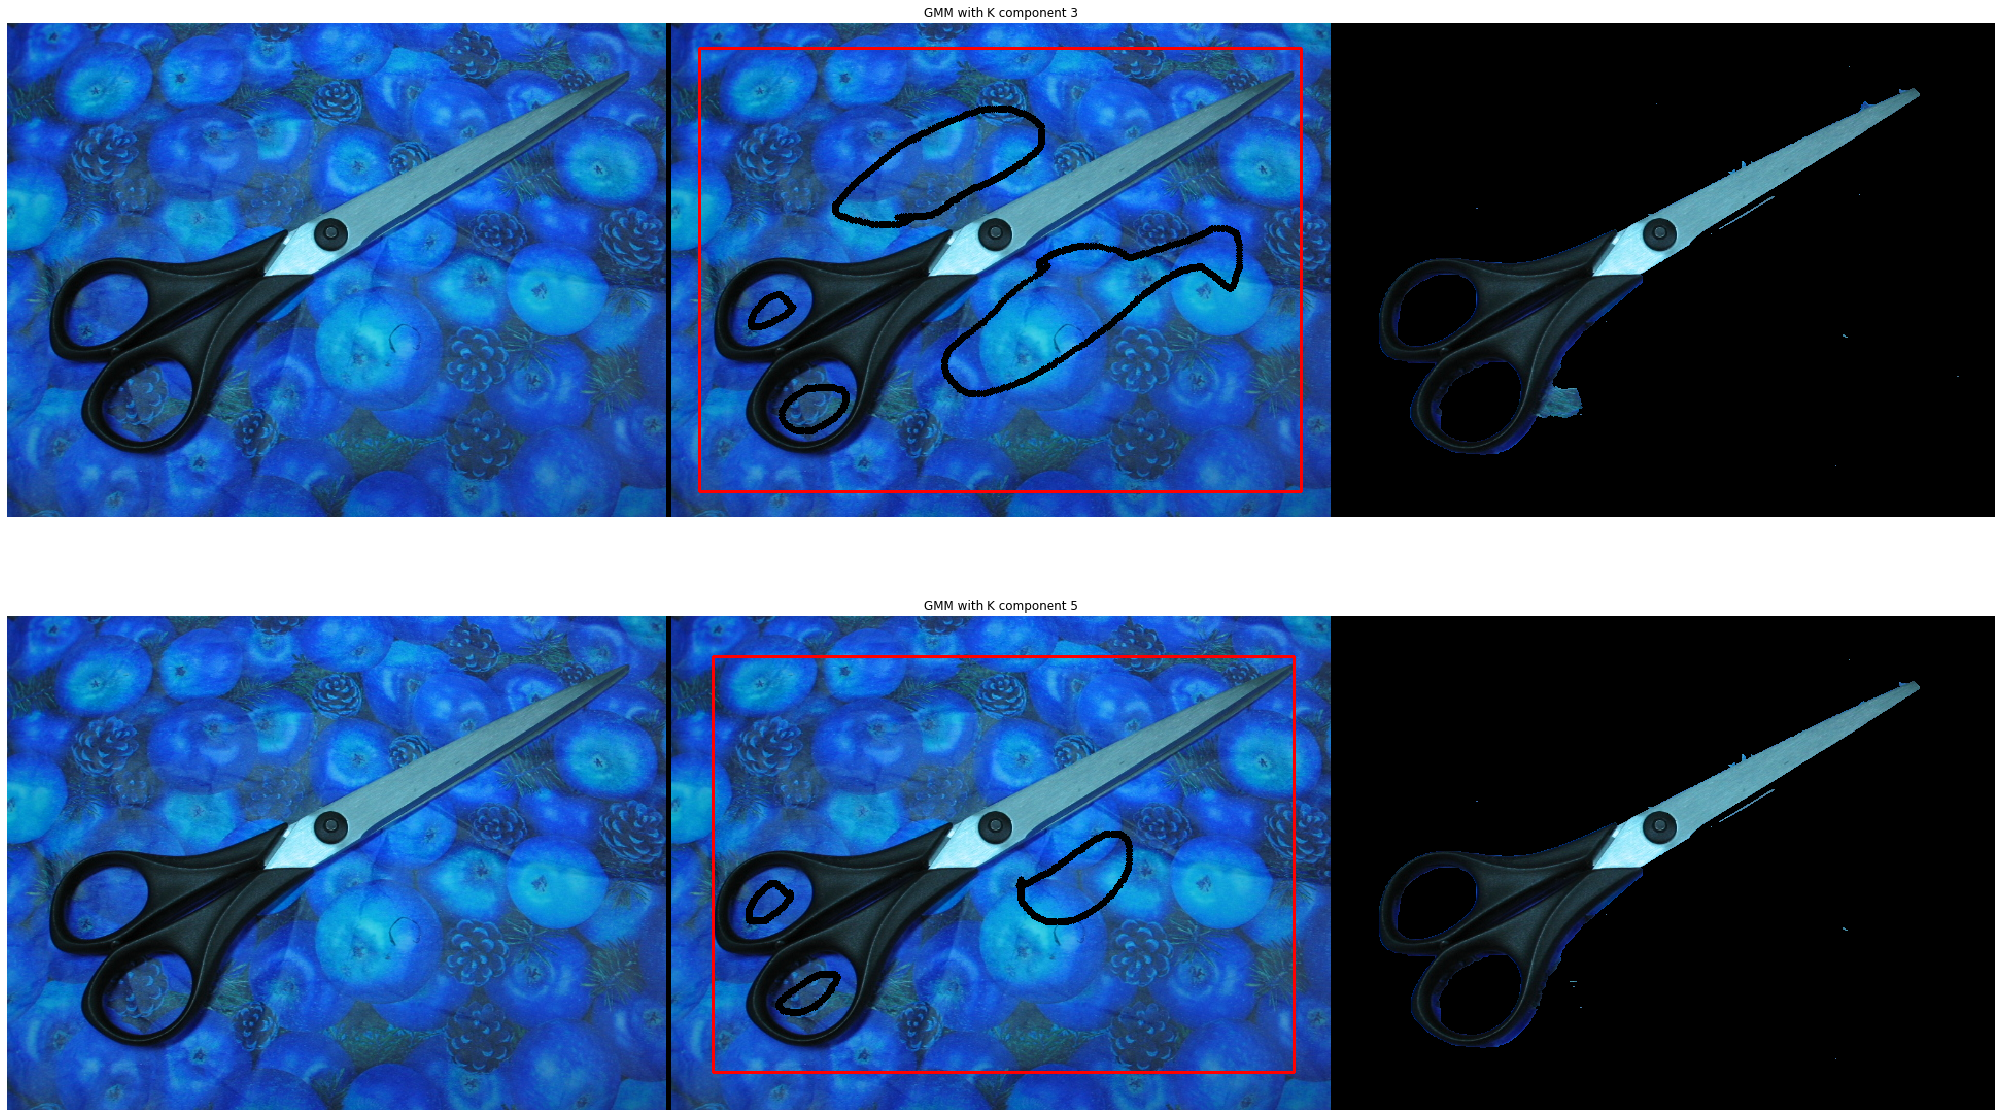

In [31]:
from matplotlib import pyplot as plt 
  
# create figure 
fig = plt.figure(figsize=(100, 20)) 
  
# setting values to rows and column variables 
rows = 2
columns = 1

# reading images 
Image1 = cv2.imread('grabcut_output_bgk3.png', cv2.IMREAD_UNCHANGED) 
Image2 = cv2.imread('grabcut_output_bgk5.png', cv2.IMREAD_UNCHANGED) 
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(Image1) 
plt.axis('off') 
plt.title("GMM with K component 3") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(Image2) 
plt.axis('off') 
plt.title("GMM with K component 5") 
  


# The choice of gamma
In the research paper, gamma is given as 50. When the gamm is increased, within fewer number of iterations, segmentation is done properly. In case of gamma 25, you can see in the below picture that the same number of iterations, couln't segmented foreground properly.

Text(0.5, 1.0, 'GMM with gamma 50')

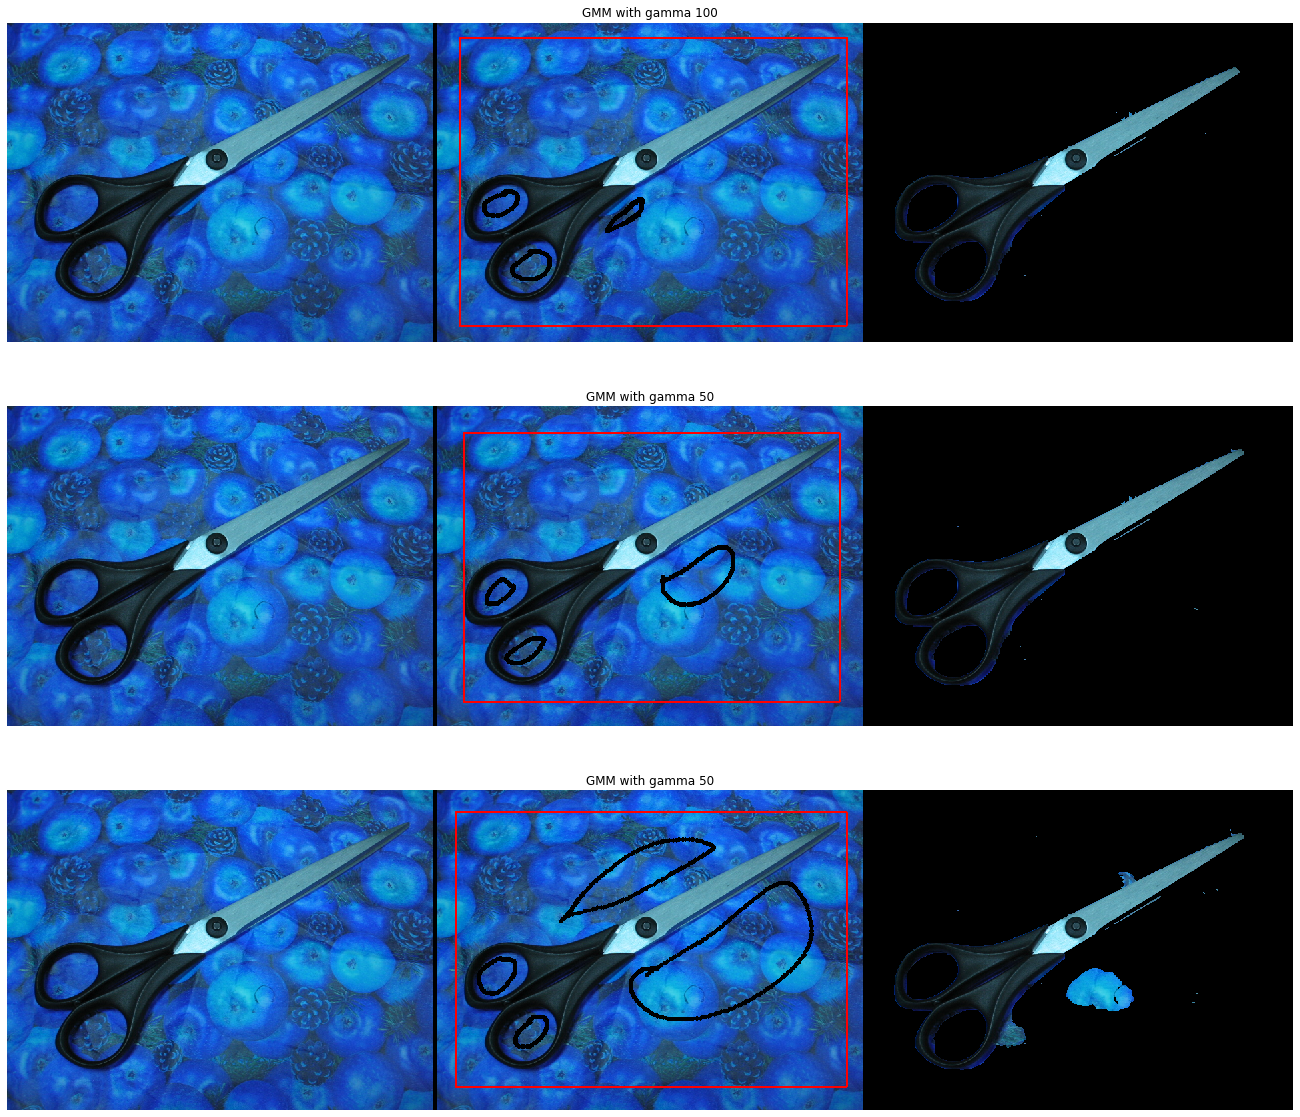

In [47]:

  
# create figure 
fig = plt.figure(figsize=(50, 20)) 
  
# setting values to rows and column variables 
rows = 3
columns = 1

# reading images 
Image1 = cv2.imread('grabcut_output_bgk5_gamma100.png', cv2.IMREAD_UNCHANGED) 
Image2 = cv2.imread('grabcut_output_bgk5.png', cv2.IMREAD_UNCHANGED) 
Image3 = cv2.imread('grabcut_output_bgk5_gamma25.png', cv2.IMREAD_UNCHANGED) 
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(Image1) 
plt.axis('off') 
plt.title("GMM with gamma 100") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(Image2) 
plt.axis('off') 
plt.title("GMM with gamma 50") 

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(Image3) 
plt.axis('off') 
plt.title("GMM with gamma 50") 
  

# Effect of a tight initial bounding box or a loose bounding box

Different bounding box dimensions are drawn on images to capture the results. It has been observed that smaller the bounding box around object is yielding better results. The following diagrams depicts the difference.]

Case - 1:
==========
bounding box1 (x,y,w,h) - (27, 18, 526, 402)
Initial background/foreground count - bgd count: 58548, fgd count: 211452

Case - 2:
==========
bounding box1 (x,y,w,h) - (150, 77, 306, 315)
Initial background/foreground count - bgd count: 173610, fgd count: 96390



Text(0.5, 1.0, 'Segmentation with bounding box (150, 77, 306, 315)')

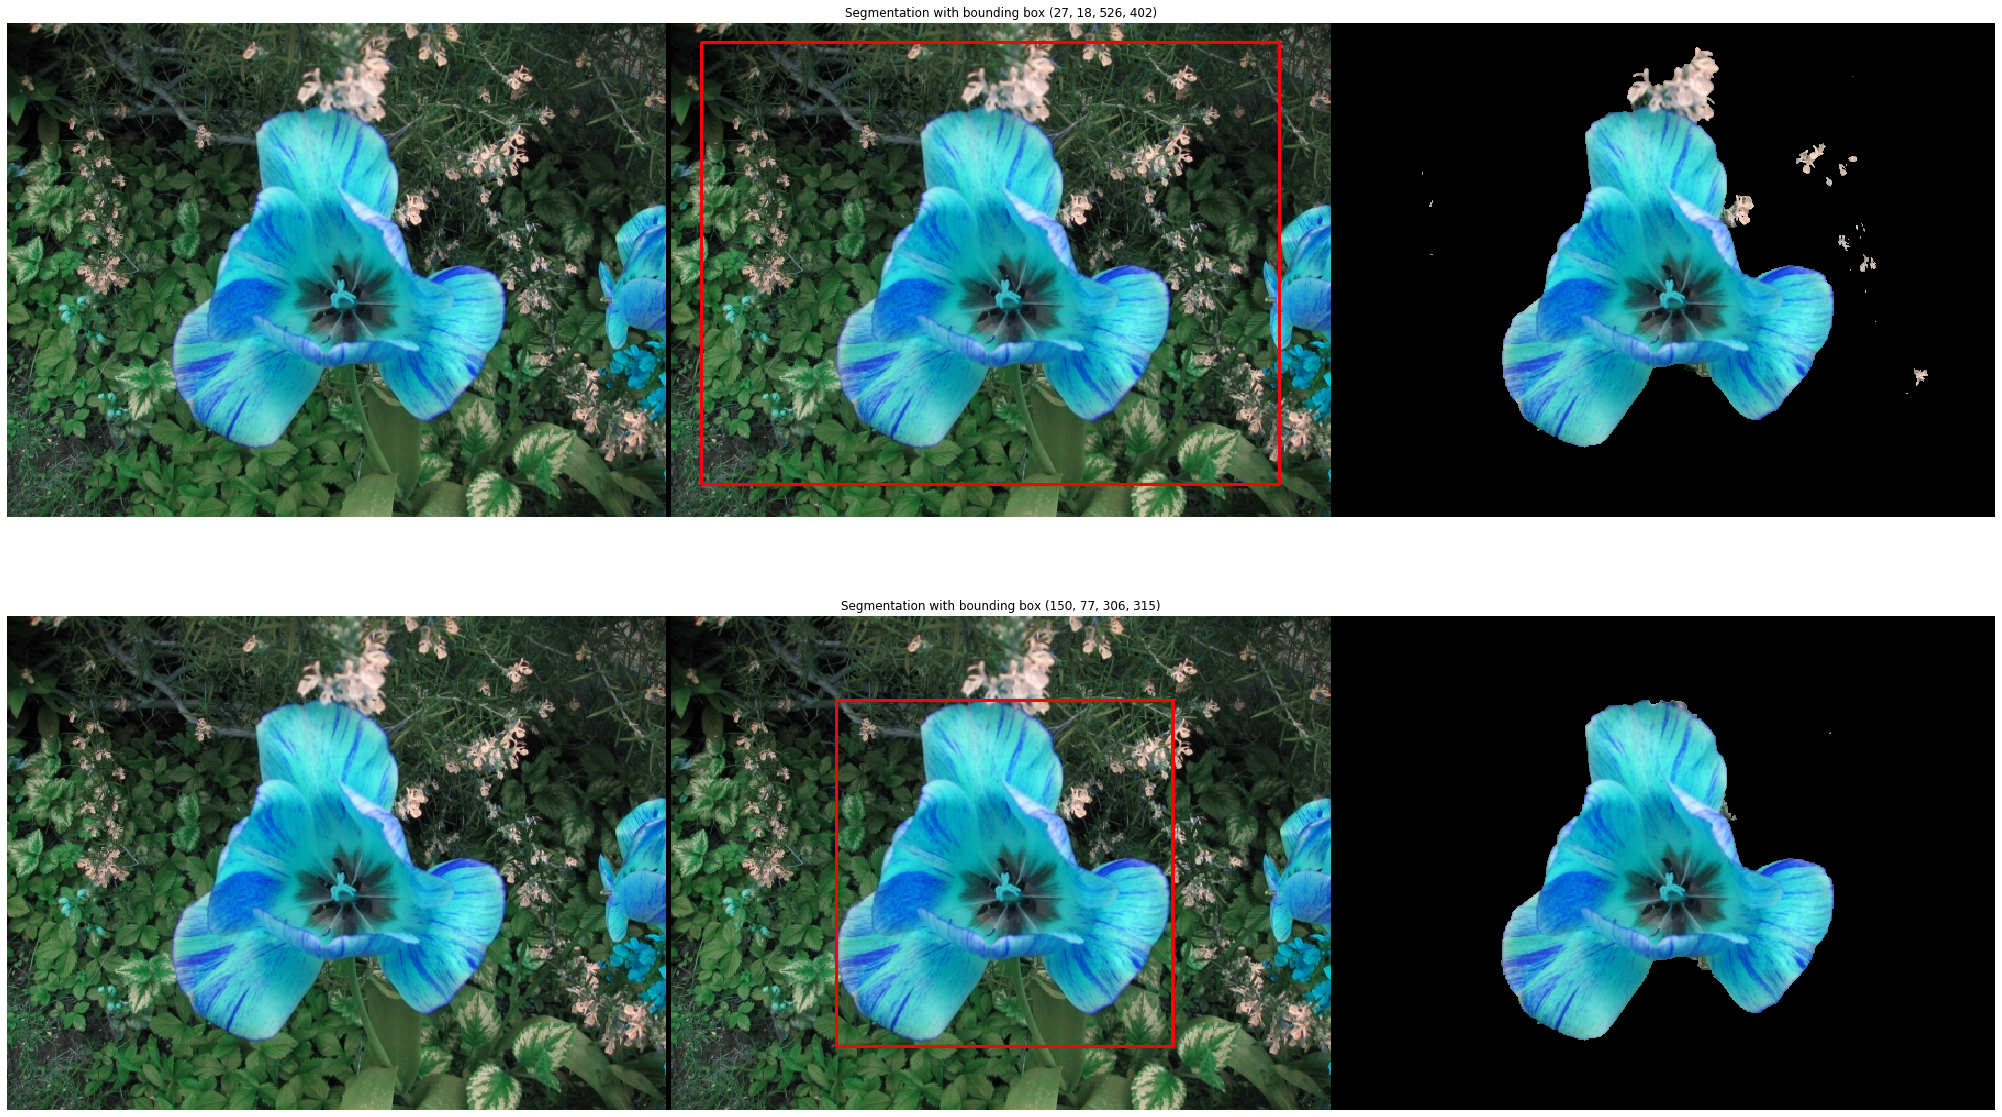

In [54]:
# create figure 
fig = plt.figure(figsize=(50, 20)) 
  
# setting values to rows and column variables 
rows = 2
columns = 1

# reading images 
Image1 = cv2.imread('grabcut_output_bg_flowerbox1.png', cv2.IMREAD_UNCHANGED) 
Image2 = cv2.imread('grabcut_output_bg_flowerbox2.png', cv2.IMREAD_UNCHANGED) 

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(Image1) 
plt.axis('off') 
plt.title("Segmentation with bounding box (27, 18, 526, 402)") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(Image2) 
plt.axis('off') 
plt.title("Segmentation with bounding box (150, 77, 306, 315)") 